## PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will remind you how to use pytorch low and high-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

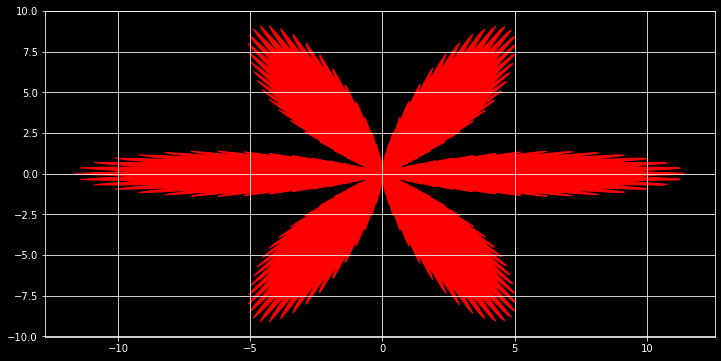

In [4]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
### YOUR CODE HERE
rho = (1+0.9*torch.cos(6*theta))*(1+0.01*torch.cos(24*theta))*(0.5+0.05*torch.cos(200*theta))*(10+torch.cos(10*theta))
# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho*torch.cos(theta) ### YOUR CODE HERE
y = rho*torch.sin(theta) ### YOUR CODE HERE


plt.figure(figsize=(12, 6))
plt.fill(x.numpy(), y.numpy(), color='red')
plt.grid()

### Task 2: Using the Dataloader

In [5]:
from torch import nn
from torch.nn import functional as F

In [6]:
!wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/week00p2_General_recap_and_vanishng_gradients/notmnist.py -ncc

--2022-11-08 15:29:48--  https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/week00p2_General_recap_and_vanishng_gradients/notmnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1799 (1,8K) [text/plain]
Saving to: 'notmnist.py'

     0K .                                                     100% 14,0K=0,1s

2022-11-08 15:29:51 (14,0 KB/s) - 'notmnist.py' saved [1799/1799]



In [7]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist()

Extracting ...
Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [8]:
class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        self.data, self.labels, _ ,_  = load_notmnist(path=path,
                                                      letters=letters, 
                                                      test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [9]:
full_dataset = DatasetMNIST('./notMNIST_small', 'AB', transform=None)

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [10]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [11]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

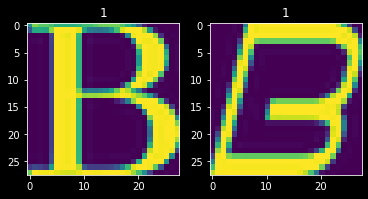

In [12]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28,28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [13]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True)

We can use dataloader as iterator by using iter() function.

In [14]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [15]:
images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\asus\anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


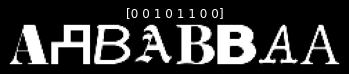

In [16]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

And now with transformations:

In [17]:
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [18]:
img, lab = train_dataset_with_transform.__getitem__(0)

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [19]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = train_iter_tr.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


In [20]:
grid = torchvision.utils.make_grid(images)
grid.shape

torch.Size([3, 32, 242])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


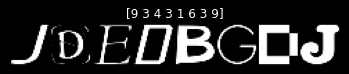

In [21]:


plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [22]:
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [23]:
a = Flatten()

In [24]:
img.shape, a(img).shape

(torch.Size([1, 28, 28]), torch.Size([784]))

In [25]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

# Putting all together

In [26]:
import time

from IPython.display import clear_output

In [27]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [28]:
def subset_ind(dataset, ratio: float):
#     return ### YOUR CODE HERE
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [29]:
dataset = DatasetMNIST(
    './notMNIST_small',
    'AB',
    transform=new_transform
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


 dataset size: 749, labels: [0 1]


In [30]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

  training size: 600
validation size: 149


In [31]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [32]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [33]:
loss_func = nn.CrossEntropyLoss()

In [34]:
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.Sigmoid(),
)

model(images).shape

torch.Size([32, 2])

In [44]:
_,y_pred = torch.max(model(images), 1)

In [45]:
(y_pred == labels)

tensor([ True,  True,  True,  True,  True, False,  True, False,  True, False,
        False,  True, False,  True,  True, False, False, False, False, False,
        False,  True, False,  True,  True,  True, False, False, False, False,
         True,  True])

In [53]:
model(images).dtype, y.dtype

(torch.float32, torch.float32)

In [58]:
loss_func(model(images), labels.long())

tensor(0.6994, grad_fn=<NllLossBackward0>)

In [37]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [59]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            ### YOUR CODE HERE
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            output = model(X_batch)
            loss = loss_fn(output, y_batch.long())
            ep_train_loss.append(loss.item())

            loss.backward()
            opt.step()
            opt.zero_grad()
            



        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                ### YOUR CODE HERE
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # compute predictions
                ### YOUR CODE HERE
                output = model(X_batch)
                eval_loss = loss_fn(output, y_batch.long())
                ep_val_loss.append(eval_loss.item())
                _, y_pred = torch.max(output, 1) ### YOUR CODE HERE
                ep_val_accuracy.append((y_batch == y_pred).sum()/X_batch.shape[0])

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [60]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.102s
	  training loss: 0.519721
	validation loss: 0.433884
	validation accuracy: 0.915
Epoch 2 of 30 took 0.095s
	  training loss: 0.402648
	validation loss: 0.395364
	validation accuracy: 0.940
Epoch 3 of 30 took 0.086s
	  training loss: 0.377073
	validation loss: 0.384043
	validation accuracy: 0.950
Epoch 4 of 30 took 0.089s
	  training loss: 0.364436
	validation loss: 0.372524
	validation accuracy: 0.956
Epoch 5 of 30 took 0.072s
	  training loss: 0.355339
	validation loss: 0.367075
	validation accuracy: 0.956
Epoch 6 of 30 took 0.081s
	  training loss: 0.348791
	validation loss: 0.370436
	validation accuracy: 0.953
Epoch 7 of 30 took 0.067s
	  training loss: 0.344581
	validation loss: 0.368597
	validation accuracy: 0.956
Epoch 8 of 30 took 0.083s
	  training loss: 0.340552
	validation loss: 0.358941
	validation accuracy: 0.962
Epoch 9 of 30 took 0.100s
	  training loss: 0.336945
	validation loss: 0.360363
	validation accuracy: 0.959
Epoch 10 of 30 took 0.068s
	

In [61]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

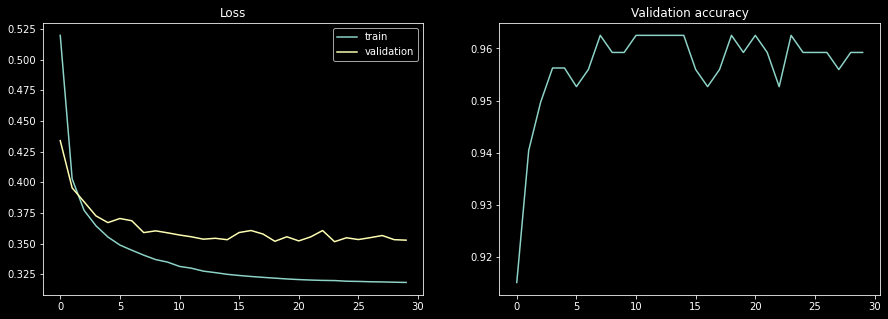

In [62]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Real network

In [63]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 2),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [64]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.307s
	  training loss: 0.423422
	validation loss: 0.367374
	validation accuracy: 0.934
Epoch 2 of 30 took 0.326s
	  training loss: 0.338584
	validation loss: 0.356863
	validation accuracy: 0.956
Epoch 3 of 30 took 0.365s
	  training loss: 0.327674
	validation loss: 0.354084
	validation accuracy: 0.959
Epoch 4 of 30 took 0.329s
	  training loss: 0.323426
	validation loss: 0.358585
	validation accuracy: 0.950
Epoch 5 of 30 took 0.298s
	  training loss: 0.318213
	validation loss: 0.361878
	validation accuracy: 0.947
Epoch 6 of 30 took 0.288s
	  training loss: 0.315925
	validation loss: 0.353003
	validation accuracy: 0.959
Epoch 7 of 30 took 0.371s
	  training loss: 0.316909
	validation loss: 0.361946
	validation accuracy: 0.962
Epoch 8 of 30 took 0.291s
	  training loss: 0.318869
	validation loss: 0.350750
	validation accuracy: 0.962
Epoch 9 of 30 took 0.294s
	  training loss: 0.320182
	validation loss: 0.368277
	validation accuracy: 0.940
Epoch 10 of 30 took 0.337s
	

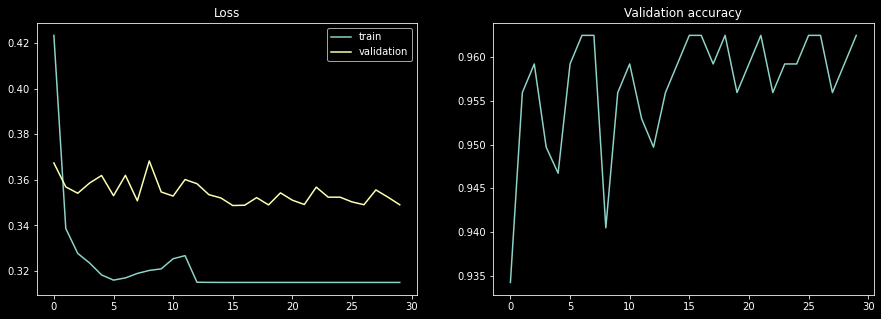

In [65]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

### Dropout try

In [85]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.Linear(200, 2),
    nn.Sigmoid(),
)
model.to(device, torch.float32)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, 
                                                 loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.146s
	  training loss: 0.438178
	validation loss: 0.391286
	validation accuracy: 0.912
Epoch 2 of 30 took 0.166s
	  training loss: 0.351336
	validation loss: 0.365866
	validation accuracy: 0.943
Epoch 3 of 30 took 0.227s
	  training loss: 0.331543
	validation loss: 0.357874
	validation accuracy: 0.950
Epoch 4 of 30 took 0.190s
	  training loss: 0.328077
	validation loss: 0.374522
	validation accuracy: 0.931
Epoch 5 of 30 took 0.180s
	  training loss: 0.324707
	validation loss: 0.349312
	validation accuracy: 0.962
Epoch 6 of 30 took 0.198s
	  training loss: 0.324860
	validation loss: 0.371987
	validation accuracy: 0.937
Epoch 7 of 30 took 0.173s
	  training loss: 0.326442
	validation loss: 0.350506
	validation accuracy: 0.962
Epoch 8 of 30 took 0.166s
	  training loss: 0.323755
	validation loss: 0.360707
	validation accuracy: 0.953
Epoch 9 of 30 took 0.195s
	  training loss: 0.323619
	validation loss: 0.347182
	validation accuracy: 0.969
Epoch 10 of 30 took 0.178s
	

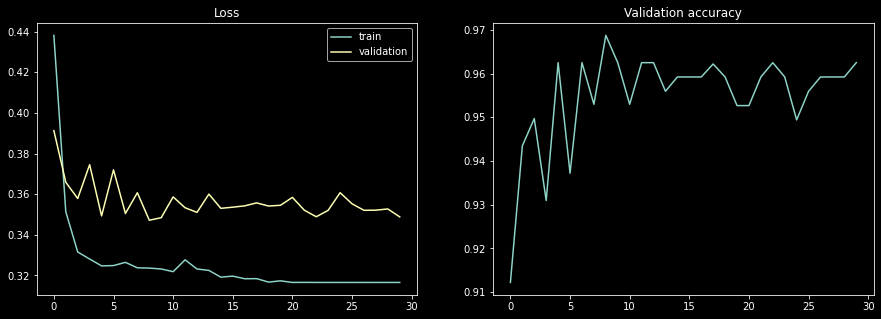

In [86]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Batchnorm try

In [87]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.Linear(200, 2),
    nn.Sigmoid(),
)
model.to(device, torch.float32)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, 
                                                 loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.155s
	  training loss: 0.446554
	validation loss: 0.375260
	validation accuracy: 0.950
Epoch 2 of 30 took 0.191s
	  training loss: 0.361985
	validation loss: 0.371885
	validation accuracy: 0.947
Epoch 3 of 30 took 0.195s
	  training loss: 0.342050
	validation loss: 0.357528
	validation accuracy: 0.962
Epoch 4 of 30 took 0.183s
	  training loss: 0.336510
	validation loss: 0.363661
	validation accuracy: 0.950
Epoch 5 of 30 took 0.180s
	  training loss: 0.331230
	validation loss: 0.353217
	validation accuracy: 0.965
Epoch 6 of 30 took 0.177s
	  training loss: 0.324048
	validation loss: 0.354571
	validation accuracy: 0.962
Epoch 7 of 30 took 0.176s
	  training loss: 0.324646
	validation loss: 0.354637
	validation accuracy: 0.965
Epoch 8 of 30 took 0.171s
	  training loss: 0.324455
	validation loss: 0.363403
	validation accuracy: 0.943
Epoch 9 of 30 took 0.188s
	  training loss: 0.325105
	validation loss: 0.366873
	validation accuracy: 0.934
Epoch 10 of 30 took 0.229s
	

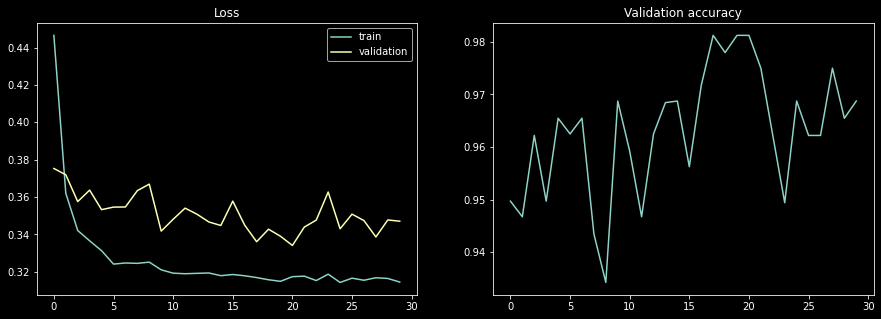

In [88]:
plot_train_process(train_loss, val_loss, val_accuracy)

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [66]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [91]:
# create network again just in case
Net = nn.Sequential(
    nn.Linear(784, 500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(),
    nn.Linear(200, 2),
    nn.Sigmoid(),
)

In [73]:
import torch.optim as optim

#### Define a training loop with model checkpointing

In [92]:
def train_save(model, epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target.long())
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [93]:
train_save(Net, 35, save_interval=500, log_interval=100)

Train Epoch: 0 [0/600 (0%)]	Loss: -0.547661
Train Epoch: 5 [160/600 (26%)]	Loss: -0.548326
Train Epoch: 10 [320/600 (53%)]	Loss: -0.544793
Train Epoch: 15 [480/600 (79%)]	Loss: -0.556025
Train Epoch: 21 [32/600 (5%)]	Loss: -0.541334
Train Epoch: 26 [192/600 (32%)]	Loss: -0.550578
model saved to mnist-500.pth
Train Epoch: 31 [352/600 (58%)]	Loss: -0.545684
model saved to mnist-665.pth


In [96]:
# create a new model
model = Net.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('mnist-665.pth', model, optimizer)
# should give you the final model accuracy
# test()

model loaded from mnist-665.pth


```

```

```

```

```

```

```

```

```

```
### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)